# Assignment 1: Classification with Naive Bayes

In [4]:
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import operator
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [5]:
def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

In [6]:
all_docs, all_labels = read_documents('all_sentiment_shuffled.txt')

In [7]:
def train_test_split(x, y, test_size=0.2):
    split_point = int((1-test_size)*len(all_docs))
    train_docs = all_docs[:split_point]
    train_labels = all_labels[:split_point]  
    test_docs = all_docs[split_point:]
    test_labels = all_labels[split_point:]
    return train_docs, train_labels, test_docs, test_labels

In [8]:
train_docs, train_labels, test_docs, test_labels = train_test_split(all_docs,
                                                                    all_labels, test_size=0.2)   

> Helper functions

In [9]:
def count(docs):
    return Counter(w for doc in docs for w in doc)

In [10]:
def clean_dict(dictionary):
    for k in list(dictionary):
            if (dictionary[k] < 100) or (dictionary[k] > 5000):
                del dictionary[k]

> Estimating parameters for the Naive Bayes classifier

In [11]:
def train_nb(documents, labels, plot=True): 
    
    ind, label_counts, priors = ({} for _ in range(3))
       
    for k in set(labels):
        
        ind[k] = np.where(np.array(labels)==k)
        # Manually remove some stopwords that are potentially uninformative #
        stop = ['the','and','to','is','.',',','a','it','this','that','of','i','in','for','"','you','(',')',"'s"]
        label_counts[k] = Counter(w for doc in np.array(documents)[ind[k]] for w in doc if w not in stop)
        label_counts[k]['UNKNOWN'] = 1
        
        if plot:
            #Plot bar with values from dict and label with keys
            plt.figure(figsize=(15,10))
            plt.title(k)
            plt.bar(range(len(OrderedDict(label_counts[k].most_common(50)))), 
                    OrderedDict(label_counts[k].most_common(50)).values(), align='center')
            plt.xticks(range(len(OrderedDict(label_counts[k].most_common(50)))), 
                       OrderedDict(label_counts[k].most_common(50)).keys())

            #Rotate labels by 90 degrees so you can see them
            locs, labeling = plt.xticks()
            plt.setp(labeling, rotation=90)

        #clean_dict(label_counts[k])
        total = sum(label_counts[k].values())
        priors[k] = len(np.array(documents)[ind[k]]) / len(documents)
    
        for key in label_counts[k]:
            label_counts[k][key] = np.log((label_counts[k][key]+1)/(total+len(label_counts[k])))
            
    return label_counts, priors

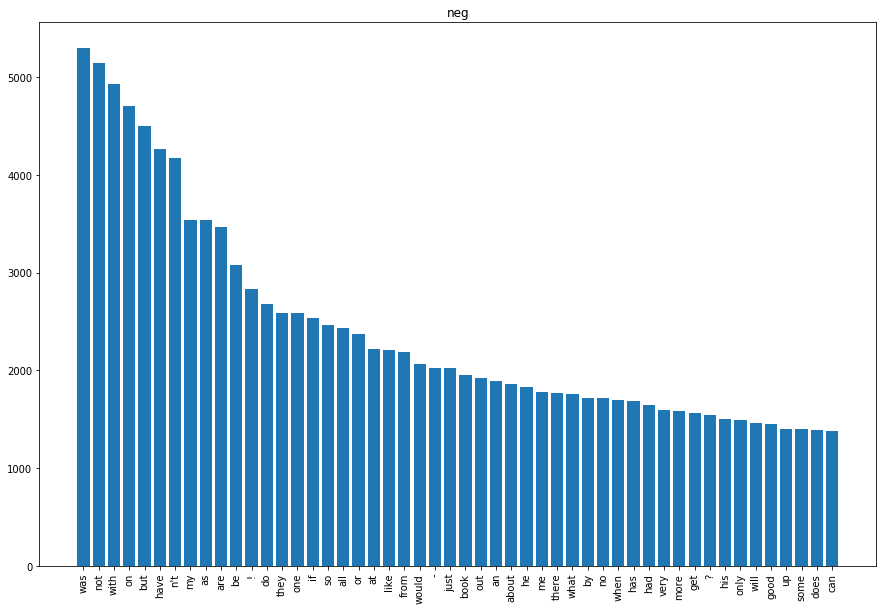

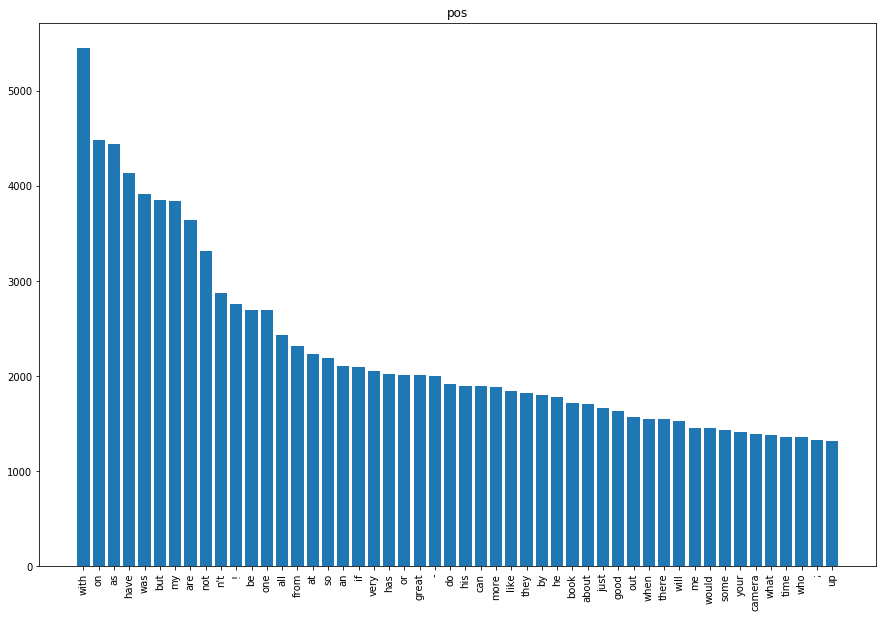

In [12]:
label_counts, priors =  train_nb(train_docs, train_labels, plot=True)

> Classifying new documents

In [13]:
def compute_logprob(document, label, label_counts, priors):
    
    labels = label_counts[label]
    keys = len(labels)
    log_l = {}
    log_l[tuple(document)] = 0
    
    for i in document:
        if labels[i] != 0:
            log_l[tuple(document)] += labels[i]
        else:
            log_l[tuple(document)] += label_counts[label]['UNKNOWN']

    log_l[tuple(document)] += np.log(priors[label])
            
    return list(log_l.values())

In [14]:
compute_logprob(['it','is','yuggggggggg'],'pos',label_counts, priors)[0]

-38.000773967413586

In [15]:
def classify_nb(document, label_counts, priors):
    probs = {}
    for key in label_counts.keys():
        probs[key] = compute_logprob(document, key, label_counts, priors)
    return max(probs.items(), key=operator.itemgetter(1))[0]

In [16]:
classify_nb(['I','hate','my','camera'],label_counts,priors)

'neg'

> Evaluating the classifier

In [17]:
def classify_documents(docs, label_counts, priors):
    results = [classify_nb(doc, label_counts,priors) for doc in docs]
    return results

In [18]:
model_predictions = classify_documents(test_docs, label_counts, priors)

In [19]:
def accuracy(true_labels, guessed_labels):
    return np.sum(np.array(true_labels) == np.array(guessed_labels)) / len(true_labels)

In [20]:
print("Test Accuracy: " + str(round(accuracy(test_labels, model_predictions)*100,2)) + " % ")

Test Accuracy: 82.04 % 


In [21]:
n_success = np.sum(np.array(test_labels) == np.array(model_predictions))

In [22]:
n = len(test_labels)

In [23]:
n_fail = n - n_success

> Error analysis

In [24]:
ind = np.where(np.array(test_labels)!=np.array(model_predictions))

In [25]:
failed_df = pd.DataFrame(np.column_stack([np.array(test_docs)[ind], np.array(model_predictions)[ind]]), columns=['doc','bad_label'])

In [26]:
failed_df['pos_log_prob'] = pd.Series(compute_logprob(document, 'pos', label_counts, priors)[0] for document in failed_df.iloc[:,0])
failed_df['neg_log_prob'] = pd.Series(compute_logprob(document, 'neg', label_counts, priors)[0] for document in failed_df.iloc[:,0])
failed_df['diff'] = np.abs(failed_df['pos_log_prob']-failed_df['neg_log_prob'])

In [27]:
failed_df.sort_values('diff', ascending=True)

,doc,bad_label,pos_log_prob,neg_log_prob,diff
53,"[i, love, the, firm, workouts, ,, and, i, love, the, instructor, allie, ,, so, i, was, so, excited, to, try, this, new, workout, ., i, was, unfortunately, extremely, disappointed, ., this, workout, was, not, complicated, ,, but, it, also, was, n't, much, of, a, workout, ., i, did, n't, get, my, heart, rate, up, at, all, ,, and, did, n't, break, a, sweat, ., some, of, the, moves, are, just, not, very, good, ,, and, having, to, repeat, them, everytime, we, add, on, got, really, annoying, ., the, disco, part, was, my, favorite, ,, but, overall, ,, this, is, a, ...]",pos,-1565.408410,-1565.413229,0.004819
123,"[the, pressure, on, the, rain, setting, is, so, low, you, have, to, keep, it, on, the, concentrated, spray, to, really, wash, the, soap, out, ., switching, between, the, two, causes, a, cold, stream, to, come, out, for, a, second, or, two, till, it, clears, ., also, it, is, not, sturdy, -, when, the, showerhead, is, moved, to, a, higher, position, it, does, not, stay, and, falls, back, down, to, the, lower, position, ., i, will, be, returning, mine]",pos,-753.863680,-753.877522,0.013842
102,"[why, are, the, newer, products, getting, slower, by, the, version, ., i, still, love, version, 5., it, does, not, forever, to, open, up, in, a, web, browser., ., update, :, i, have, been, using, version, 7, now, for, several, months., ., i, am, glad, to, say, that, i, am, now, a, lot, happier, ., granted, it, still, uses, a, lot, of, memory, ., however, ,, the, new, features, that, it, has, compared, to, version, 5, ,, makes, the, upgrade, worthwhile, ., however, ,, watch, out., ., there, are, several, features, that, adobe, took, out, from, the, standard, version, and, only, ...]",pos,-984.702142,-984.719835,0.017693
308,"[this, cd, is, ,, without, a, doubt, amazing, ., stars, are, lost, because, prior, to, recording, ,, you, would, think, the, guitarist, would, invest, in, a, damn, noise, gate, for, his, guitar, rig, ., his, tone, is, crushing, &, sounds, perfect, ,, but, the, second, he, stops, playing, ,, every, time, ssssqqqqqquuuueeeaaaalllll, ., it, 's, annoying, to, the, point, of, only, being, able, to, tolerate, so, many, songs, at, once, ,, because, it, is, a, chronic, problem, in, every, song, .]",pos,-777.804985,-777.833455,0.028470
41,"[jet, li, as, a, contrac, killer, ?, come, on, !, the, reason, why, this, movie, is, n't, that, famous, is, because, it, pretty, much, sucks, ., it, 's, just, a, shootem, up, bang, bang, type, of, movie, ., no, realy, kung, fu, here]",pos,-405.946571,-405.980919,0.034349
359,"[camera, arrived, earlier, than, i, expected, ,, and, was, just, what, i, wanted, ., very, small, ,, but, versitle, ., large, screen, ., very, satified, with, my, purchase]",neg,-244.921654,-244.880647,0.041007
386,"[i, purchase, this, on, december, 2006, i, have, other, 10x50, binocular, but, when, i, look, at, sky, through, this, binox..it, 's, amazing, !, !, !, i, recommend, it, for, astronomy, and, birding, trip., .]",neg,-324.316996,-324.274958,0.042037
314,"[it, is, great, to, be, able, to, read, all, the, avenger, comics, again, ., i, read, them, as, a, kid, ,, but, did, n't, get, to, read, the, very, beginning, ., i, hope, that, they, bring, out, more, of, the, comic, book, characters, on, dvd, ., i, will, buy, more]",neg,-440.627533,-440.564134,0.063399
268,"[the, seller, was, super, fast, ,, the, product, well, packaged, and, as, described, ., thank, you]",neg,-154.479511,-154.395278,0.084233
9,"[the, price, is, too, high, ,, considering, the, ijoy, 550, model, is, only, us$599.99, at, sharper, image]",pos,-169.494484,-169.585146,0.090662


In [28]:
mixed_review = ' '.join(failed_df.iloc[53,:]['doc'])

In [29]:
mixed_review

"i love the firm workouts , and i love the instructor allie , so i was so excited to try this new workout . i was unfortunately extremely disappointed . this workout was not complicated , but it also was n't much of a workout . i did n't get my heart rate up at all , and did n't break a sweat . some of the moves are just not very good , and having to repeat them everytime we add on got really annoying . the disco part was my favorite , but overall , this is a workout that i can honestly say i would rather have the money then the workout . i will keep it and periodically do it on a very light day or in addition to another workout , but that 's just because i have it . i 've tried a couple other of the new firm workouts that are more worth the money...this one i am sad to say is not ."

The borderline example above illustrates a shortcoming of the Naive Bayes classifier, as it is unable to follow sentiment in longer sentences. In the example above, the review starts off using words with strong positive polarity (love, excited) and then moves firmly into negative territory. Therefore, since Naive Bayes only considers the polarity of individual words, the result is skewed by the strong polarity of positive words (love, excited). In addition, it is unable to infer the implication of negation on sentiment. For example, "not very good", is scored as a positive sentiment because "very good" carries strong positive polarity, whereas "not" only offers mildly negative polarity in this case. 

### 95% Bayesian Credibility Interval using Beta Prior 

![beta-pdf](https://wikimedia.org/api/rest_v1/media/math/render/svg/5fc18388353b219c482e8e35ca4aae808ab1be81)

When a = 1 and b = 1, we see that the pdf simplifies to that of the standard continuous uniform distribution on the interval (0,1)

In [30]:
#Generate x's in domain of Beta distribution
x = np.arange(0,1,0.01)

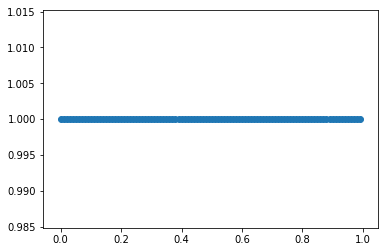

In [31]:
plt.scatter(x=x,y=stats.beta.pdf(x,1,1))

The distribution of our data, given some unknown parameter theta (representing the true accuracy as a proportion) can be thought of as the likelihood of our observed data from the sample, i.e.:

Binomial distribution with: 

In [32]:
n = len(test_labels), 
p_hat = (np.sum(np.array(test_labels) == np.array(model_predictions))) / n

In [33]:
mean = n*p_hat

In [34]:
x = np.arange(stats.binom.ppf(0.01, n, p_hat),stats.binom.ppf(0.99, n, p_hat))

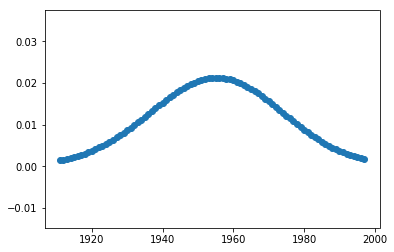

In [35]:
plt.scatter(x=x, y=stats.binom.pmf(x, n=n, 
                               p=p_hat))

As a self-check, we see that the Binomial pmf peaks here at the mean. Note that although the distribution appears to be continuous, it is discrete. 

In [36]:
mean

array([ 1955.])

Since the Beta distribution is a conjugate prior for the Binomial distribution, we find that the posterior distribution is again a Beta distribution

In [37]:
def cred_interval(a, b, true_labels, model_labels):
    
    n = len(true_labels)
    n_success = np.sum(np.array(true_labels) == np.array(model_labels))
    n_fail = n - n_success
    posterior_dist = stats.beta(n_success + a, n_fail + b)
    p_low, p_high = posterior_dist.interval(0.95)
    
    return p_low, p_high

As illustrated below, the distribution of the data helps us to update our estimation of the distribution of the parameter we are trying to estimate - namely the accuracy. 

In [38]:
a=1
b=1

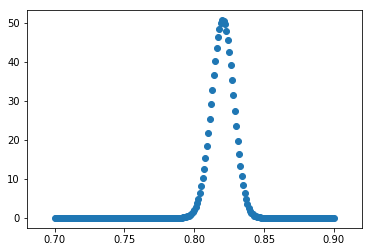

In [39]:
#Generate x's in domain of Beta distribution
x = np.arange(0.7,0.9,0.001)
plt.scatter(x=x,y=stats.beta.pdf(x,n_success+a,n_fail+b))

In [40]:
cred_interval(1, 1, test_labels, model_predictions)

(0.8044632339693899, 0.83527984351012163)

### Cross-validation procedure

In [41]:
#The number of documents we have
len(all_docs)

11914

In [42]:
def cv_docs(documents,labels,priors, N=10):
    
    total_suc = 0
    total = 0
    
    for fold in range(N):
        
        fold_start = int(fold * (int(len(documents))/N))
        fold_end = int((fold+1) * (int(len(documents))/N))

        train_docs_fold = documents[:fold_start] + documents[fold_end:]
        train_labels_fold = labels[:fold_start] + labels[fold_end:]
        test_docs_fold = documents[fold_start:fold_end]
        test_labels_fold = labels[fold_start:fold_end]

        label_counts, priors = train_nb(train_docs_fold, train_labels_fold, plot=False)
        model_pred = classify_documents(test_docs_fold, label_counts, priors)
        model_acc = accuracy(test_labels_fold, model_pred)
        
        n = len(test_labels_fold)
        n_success = np.sum(np.array(test_labels_fold) == np.array(model_pred))
        total_suc += n_success
        total += n
        
    posterior_dist = stats.beta(total_suc + 1, total-total_suc + 1)
    p_low, p_high = posterior_dist.interval(0.95)
    
    return total_suc, total, total_suc/total, [p_low,p_high]

In [43]:
total_suc, total, ratio, interval = cv_docs(all_docs, all_labels, priors)

<i> Cross-validation results </i>

In [46]:
ratio

0.81442001007218401

In [47]:
interval

[0.80733677008652582, 0.8212977547140814]

### Comparing the accuracy to a given target value

In [48]:
if stats.binom_test(n_success, n, 0.8) < 0.05:
    print('Statistically significant difference from 80% test accuracy ' + " p-value: " + str(stats.binom_test(
        n_success, n, 0.8)[0]))
else:
    print('No statistically significant difference from 80% test accuracy'+ " p-value: " + str(stats.binom_test(
        n_success, n, 0.8)[0]))

Statistically significant difference from 80% test accuracy  p-value: 0.0129681555034


### Comparing two classifiers

In [49]:
own_model = classify_documents(test_docs, label_counts, priors)

As a benchmark, we will be using the Multinomial Naive Bayes implementation from Scikit Learn

> In order to do this, we need to first convert our text data into feature vectors

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
X_train_counts = count_vect.fit_transform(train_docs)
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

In [51]:
def bin_decode(labels):
    for i in range(len(labels)):
        if labels[i] == 'pos':
            labels[i] = 1
        else:
            labels[i] = 0
    return labels

In [52]:
clf = MultinomialNB(class_prior=[priors['neg'],priors['pos']]).fit(X_train_tf, train_labels)

In [53]:
X_new_counts = count_vect.transform(test_docs)

In [54]:
predicted = clf.predict(X_new_counts)

> SKlearn Model

In [55]:
accuracy(test_labels,predicted)

0.82249265631556856

> Our Model

In [56]:
accuracy(test_labels, model_predictions)

0.82039446076374323

In [57]:
ind_correct_sk = np.where(np.array(test_labels)==predicted)[0]

In [58]:
ind_correct_mod = np.where(np.array(test_labels)==np.array(model_predictions))[0]

In [59]:
counts = np.zeros(shape=(2,2))
counts[0][0] = len(list(set(list(ind_correct_sk)) & set(list(ind_correct_mod))))
counts[0][1] = len(list(set(ind_correct_sk) - set(ind_correct_mod)))
counts[1][0] = len(list(set(ind_correct_mod) - set(ind_correct_sk)))
counts[1][1] = len(test_labels) - (counts[0][0] + counts[0][1] + counts[1][0] )  

In [60]:
counts

array([[ 1868.,    92.],
       [   87.,   336.]])

In [61]:
B = counts[0][1] 
C = counts[1][0] 

> McNemar test

In [62]:
p_value = stats.binom_test(B, B+C, 0.5)

In [63]:
p_value

0.76505741994872967

Conclusion: p-value is significantly higher than 0.05, and thus we cannot say that the performance of the SKLearn model is significantly different from our model. 

### Optional Task

(Optional) Implement a six-category classifier

In [465]:
def read_documents_cat(doc_file):
    docs = []
    categories = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            categories.append(words[0])
    return docs, categories

In [466]:
def train_test_split(x, y, test_size=0.2):
    split_point = int((1-test_size)*len(all_docs))
    train_docs = d[:split_point]
    train_labels = c[:split_point]  
    test_docs = d[split_point:]
    test_labels = c[split_point:]
    return train_docs, train_labels, test_docs, test_labels

In [467]:
d,c = read_documents_cat('all_sentiment_shuffled.txt')

In [468]:
td, tl, ted, tel = train_test_split(d,c, test_size=0.2) 

In [469]:
lc, p = train_nb(td,tl,plot=False)

In [470]:
lc.keys()

dict_keys(['music', 'camera', 'dvd', 'health', 'software', 'books'])

In [471]:
classify_nb(['I','hate','my','camera'],lc,p)

'camera'

In [472]:
model_predictions = classify_documents(test_docs, lc, p)

In [475]:
print("Test Accuracy: " + str(round(accuracy(tel, model_predictions)*100,2)) + " % ")

Test Accuracy: 69.41 % 


(Optional) Learning curve

In [188]:
def learning_curve(r=np.arange(0.1,1,0.1)):
    acc = []
    for i in r:
        train_docs, train_labels, test_docs, test_labels = train_test_split(all_docs,
                                                                            all_labels, test_size=i)
        label_counts, priors =  train_nb(train_docs, train_labels, plot=False)
        model_predictions = classify_documents(test_docs, label_counts)
        a = accuracy(test_labels, model_predictions)
        try:
            acc.append(np.round(a,2))
        except:
            acc.append(0)
    return acc

In [189]:
accuracies = learning_curve()

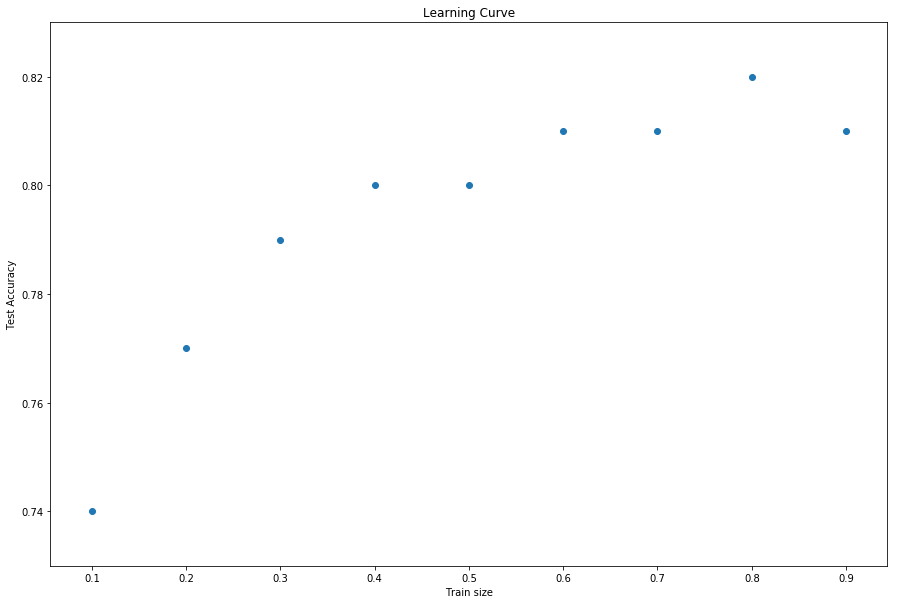

In [190]:
plt.figure(figsize=(15,10))
plt.scatter(x=1-np.arange(0.1, 1, 0.1),y=accuracies)
plt.xlabel('Train size')
plt.ylabel('Test Accuracy')
plt.title('Learning Curve')

(Optional) Print the informative features

<i> Polarity investigation </i>

In [191]:
def print_nb(n, docs, polarity='pos'):
    counted = count(docs)
    ind = {}
    for k in set(train_labels):
        ind[k] = np.where(np.array(train_labels)==k)
    
    pos_counted = count(np.array(all_docs)[ind['pos']])
    neg_counted = count(np.array(all_docs)[ind['neg']])
    
    pos_neg_ratios = Counter()
    
    for term,cnt in list(counted.most_common()):
        if(cnt > 100):
            pos_neg_ratio = pos_counted[term] / float(neg_counted[term]+1)
            pos_neg_ratios[term] = pos_neg_ratio
    
    if polarity=='pos':
        print(pos_neg_ratios.most_common()[0:int(n)])
    else:
        print(list(reversed(pos_neg_ratios.most_common()))[0:int(n)])

<i> Negative words </i>

In [192]:
print_nb(n=10, docs=all_docs, polarity='neg')

[('refund', 0.054945054945054944), ('warranty', 0.06666666666666667), ('repair', 0.07058823529411765), ('disappointing', 0.09), ('waste', 0.09287925696594428), ('garbage', 0.09574468085106383), ('horrible', 0.09836065573770492), ('boring', 0.1111111111111111), ('ridiculous', 0.11904761904761904), ('disappointment', 0.12)]


<i> Positive words </i>

In [477]:
print_nb(n=10, docs=all_docs, polarity='pos')

[('illustrator', 8.909090909090908), ('allows', 5.2631578947368425), ('lenses', 4.785714285714286), ('season', 4.686274509803922), ('amazing', 4.545454545454546), ('superb', 4.470588235294118), ('excellent', 4.41), ('helps', 4.260869565217392), ('photoshop', 4.071428571428571), ('outstanding', 4.0588235294117645)]


(Optional) Naive Bayes for numerical data

In [193]:
import pandas as pd

iris = pd.read_csv('iris.csv')

# separate the four numerical columns and the categorical column
X = iris.iloc[:,:4]
Y = iris['species']

# split into a training and a test set; note that the data isn't shuffled!
n = len(Y)
n_test = 40
eval_part = np.array([False]*n)
for i in np.random.choice(range(n), replace=False, size=n_test):
    eval_part[i] = True
Xeval = X[eval_part]
Yeval = Y[eval_part]
Xtrain = X[~eval_part]
Ytrain = Y[~eval_part]
df_train = iris[~eval_part]
df_eval = iris[eval_part]

In [194]:
def train_nb(x, y): 
    params = {}
    for k in set(y):
        params[k] = [l for l in zip(np.mean(x[x['species']==k]),np.std(x[x['species']==k]))] 
    return params 

In [195]:
params = train_nb(df_train, Ytrain)

In [196]:
params

{'Iris-setosa': [(5.0225806451612902, 0.32697013518486606),
  (3.4096774193548387, 0.38550749016586622),
  (1.5161290322580643, 0.15881978871085381),
  (0.27096774193548384, 0.11693270297027004)],
 'Iris-versicolor': [(5.908888888888888, 0.52697131367096139),
  (2.7733333333333334, 0.2870540018881465),
  (4.2311111111111108, 0.47273305703100199),
  (1.3088888888888888, 0.1786644554865936)],
 'Iris-virginica': [(6.6647058823529406, 0.60918574050611707),
  (2.9823529411764707, 0.32127557186873817),
  (5.5882352941176476, 0.55453462517594987),
  (2.0147058823529411, 0.26693505813121582)]}

In [197]:
stats.norm.pdf(2, 2, 2)

0.19947114020071635

In [198]:
example = [1,1,1,1]

In [540]:
def compute_logprob(document, key, label_counts, priors):
    log_prob = {}
    #keys = list(params.keys())
    #for i in keys:
    log_prob[key] = 0
    for j in range(len(params[key])):
        log_prob[key] += np.log(stats.norm.pdf(document[j], params[key][j][0], params[key][j][1])) 
    return list(log_prob.values())

In [541]:
compute_logprob(example, 'Iris-setosa' ,lc, p)

[-117.54666835383033]

In [542]:
def train_nb(documents, labels, plot=True): 
    
    ind, label_counts, priors = ({} for _ in range(3))
       
    for k in set(labels):
        
        ind[k] = np.where(np.array(labels)==k)
        # Manually remove some stopwords that are potentially uninformative #
        stop = ['the','and','to','is','.',',','a','it','this','that','of','i','in','for','"','you','(',')',"'s"]
        label_counts[k] = Counter(w for doc in np.array(documents)[ind[k]] for w in doc if w not in stop)
        label_counts[k]['UNKNOWN'] = 1
        
        if plot:
            #Plot bar with values from dict and label with keys
            plt.figure(figsize=(15,10))
            plt.title(k)
            plt.bar(range(len(OrderedDict(label_counts[k].most_common(50)))), 
                    OrderedDict(label_counts[k].most_common(50)).values(), align='center')
            plt.xticks(range(len(OrderedDict(label_counts[k].most_common(50)))), 
                       OrderedDict(label_counts[k].most_common(50)).keys())

            #Rotate labels by 90 degrees so you can see them
            locs, labeling = plt.xticks()
            plt.setp(labeling, rotation=90)

        #clean_dict(label_counts[k])
        total = sum(label_counts[k].values())
        priors[k] = len(np.array(documents)[ind[k]]) / len(documents)
    
        for key in label_counts[k]:
            label_counts[k][key] = np.log((label_counts[k][key]+1)/(total+len(label_counts[k])))
            
    return label_counts, priors

In [543]:
lc, p = train_nb(Xtrain, Ytrain, plot=False)

In [544]:
prediction = classify_nb([1,1,1,1], lc, p)

In [545]:
prediction

'Iris-versicolor'

In [546]:
def classify_documents(docs, label_counts, priors):
    results = [classify_nb([doc[0],doc[1],doc[2],doc[3]], label_counts,priors) for doc in docs.itertuples()]
    return results

In [550]:
predictions = classify_documents(Xeval, lc, p)

C:\Users\Jannes\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [549]:
accuracy(Yeval, predictions)

0.40000000000000002

(Optional) Train a classifier using scikit-learn

In [201]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest

In [202]:
def train_sklearn(docs, labels):
    vec = TfidfVectorizer(preprocessor = lambda x: x,
                          tokenizer = lambda x: x)
    sel = SelectKBest(k='all')
    clf = LinearSVC()
    #clf = MLPClassifier()    
    pipeline = make_pipeline(vec, sel, clf)
    pipeline.fit(docs, labels)
    return pipeline

In [204]:
v = train_sklearn(all_docs, all_labels)

In [205]:
def classify_documents_sklearn(docs, model):
    return model.predict(docs)

In [206]:
predictions = classify_documents_sklearn(all_docs, v)

In [207]:
predictions

array(['neg', 'neg', 'neg', ..., 'pos', 'neg', 'neg'],
      dtype='<U3')

(Optional) Improve the features

In [551]:
import nltk

In [558]:
def bigram_freq(docs):
    flat_list = [item for sublist in docs for item in sublist]
    bgs = nltk.bigrams(flat_list)
    return nltk.FreqDist(bgs)

In [559]:
bigram_freq(train_docs)

FreqDist({('poetic', 'technique'): 1,
          (',', 'decent'): 4,
          ('convert', 'my'): 2,
          ('cappuccino', ','): 1,
          ('at', '400'): 1,
          ('their', 'precious'): 1,
          ('can', 'unfinalize'): 1,
          ('forms....i', 'think'): 1,
          ('this', 'sort'): 9,
          ('as', '*not'): 1,
          ('are', 'sandwiched'): 1,
          ('thought', 'she'): 3,
          ('suspence', 'as'): 2,
          ('night', 'special'): 1,
          ('by', 'samsonite'): 1,
          ('book', 'where'): 1,
          ('seem', 'so'): 5,
          ('that', 'time'): 46,
          ('medium', 'wide'): 1,
          ('someone', 'exactly'): 1,
          ('run', 'now'): 1,
          ('drove', 'off'): 1,
          ("70's", '.'): 5,
          ('gaping', 'open'): 2,
          ('errors', 'keep'): 1,
          ('fosse', 'and'): 1,
          ('record', 'designed'): 1,
          ('owes', 'much'): 2,
          ('(', '175'): 1,
          ('7.', 'it'): 1,
          ('cya', 'disclaim

(Optional) Domain sensitivity

In [609]:
d,c = read_documents_cat('all_sentiment_shuffled.txt')

In [604]:
ind_camera = np.where(np.array(c)=='camera')
ind_books = np.where(np.array(c)=='books')

In [637]:
def train_test_split(x, y, test_size=0.2):
    split_point = int((1-test_size)*len(x))
    train_docs = x[:split_point]
    train_labels = y[:split_point]  
    test_docs = x[split_point:]
    test_labels = y[split_point:]
    return train_docs, train_labels, test_docs, test_labels

In [638]:
train_docs_cam, train_labels_cam, test_docs_cam, test_labels_cam = train_test_split(np.array(d)[ind_camera],
                                                                    np.array(c)[ind_camera], test_size=0.2)  

In [639]:
train_docs_books, train_labels_books, test_docs_books, test_labels_books = train_test_split(np.array(d)[ind_books],
                                                                    np.array(c)[ind_books], test_size=0.2)  

In [640]:
lc, p = train_nb(train_docs_cam, train_labels_cam, plot=False)

In [642]:
p

{'camera': 1.0}

In [643]:
def compute_logprob(document, label, label_counts, priors):
    
    labels = label_counts[label]
    keys = len(labels)
    log_l = {}
    log_l[tuple(document)] = 0
    
    for i in document:
        if labels[i] != 0:
            log_l[tuple(document)] += labels[i]
        else:
            log_l[tuple(document)] += label_counts[label]['UNKNOWN']

    log_l[tuple(document)] += np.log(priors[label])
            
    return list(log_l.values())

In [644]:
def classify_documents(docs, label_counts, priors):
    results = [classify_nb(doc, label_counts,priors) for doc in docs]
    return results

In [646]:
predictions = classify_documents(test_docs_books, lc, p)

In [647]:
predictions

['camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',
 'camera',

In [648]:
accuracy(test_labels_books, predictions)

0.0